In [1]:
# CELL 1
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt


In [2]:
#CELL 2
# Load cleaned stock data and trained model
data = pd.read_csv('../data/final_stock_data.csv', index_col=0)
model = joblib.load('../models/xgb_model.pkl')

# Define the features used in training
features = ['SMA_20', 'SMA_50', 'RSI', 'MACD', 'BB_upper', 'BB_middle', 'BB_lower']
features = [col for col in features if col in data.columns]

# Drop rows with missing values in features or close price
data = data.dropna(subset=features + ['close'])

In [3]:
#CELL 3
# Predict signals on full dataset
X = data[features]
preds = model.predict(X)

# Reverse map from [0, 1, 2] → [-1, 0, 1] = Sell, Hold, Buy
reverse_map = {0: -1, 1: 0, 2: 1}
data['predicted_signal'] = [reverse_map[p] for p in preds]

# Preview distribution
print("Predicted signal distribution:\n", data['predicted_signal'].value_counts())


Predicted signal distribution:
 predicted_signal
 0    586
 1    313
-1    309
Name: count, dtype: int64


In [4]:
#CELL 4
# Parameters for realism
transaction_cost = 0.001  # 0.1% fee per trade
cooldown_days = 1         # cooldown window to avoid overtrading
initial_cash = 1000       # starting capital

# Apply 1-day lag: prediction made today can only be executed tomorrow
data['predicted_signal'] = data['predicted_signal'].shift(1)

# Calculate next-day returns
data['next_close'] = data['close'].shift(-1)
data['price_change'] = data['next_close'] / data['close'] - 1

# Initialize tracking
capital = initial_cash
equity_curve = []
last_trade_day = -np.inf
index_list = data.index.tolist()

# Loop through data to simulate trading
for i, row in data.iterrows():
    signal = row['predicted_signal']
    day_index = index_list.index(i)

    if pd.isna(signal) or pd.isna(row['price_change']):
        equity_curve.append(capital)
        continue

    if signal == 1 and (day_index - last_trade_day) > cooldown_days:
        # Buy signal
        capital *= (1 + row['price_change'] - transaction_cost)
        last_trade_day = day_index

    elif signal == 0 and (day_index - last_trade_day) > cooldown_days:
        # Sell signal (flat the position)
        capital *= (1 - transaction_cost)
        last_trade_day = day_index

    equity_curve.append(capital)

# Final equity curve
data = data.iloc[:len(equity_curve)].copy()
data['realistic_equity'] = equity_curve

# Buy & hold baseline
data['buy_and_hold'] = (data['close'] / data['close'].iloc[0]) * initial_cash


c:\Users\123ka\OneDrive\Desktop\Projects\ai-alpha-detector\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\123ka\OneDrive\Desktop\Projects\ai-alpha-detector\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


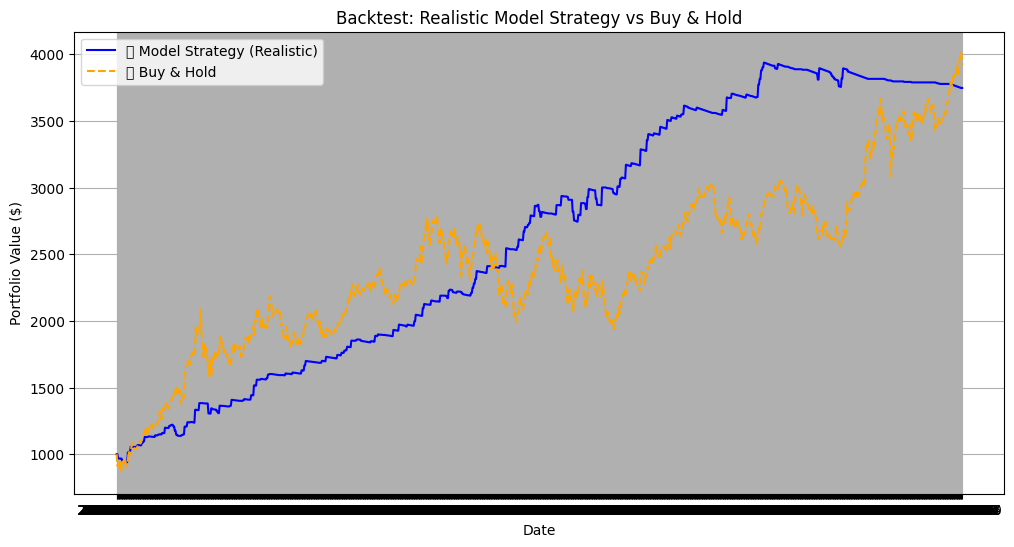

In [5]:
# CELL 5

# Compare strategy vs buy-and-hold
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['realistic_equity'], label='📈 Model Strategy (Realistic)', color='blue')
plt.plot(data.index, data['buy_and_hold'], label='📉 Buy & Hold', linestyle='--', color='orange')
plt.title("Backtest: Realistic Model Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# CELL 6
# Calculate daily returns of strategy
returns = data['realistic_equity'].pct_change().dropna()

# Metrics
total_return = data['realistic_equity'].iloc[-1] / initial_cash - 1
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
cumulative = data['realistic_equity']
peak = cumulative.cummax()
drawdown = (cumulative - peak) / peak
max_drawdown = drawdown.min()

# Trades executed
num_trades = (data['predicted_signal'] == 1).sum()
win_trades = ((data['predicted_signal'] == 1) & (data['price_change'] > 0)).sum()
win_rate = win_trades / num_trades if num_trades > 0 else 0

# Display metrics
print("📊 Realistic Strategy Performance:")
print(f"💰 Total Return:        {total_return * 100:.2f}%")
print(f"📈 Sharpe Ratio:        {sharpe_ratio:.2f}")
print(f"📉 Max Drawdown:        {max_drawdown * 100:.2f}%")
print(f"⚖️ Win Rate:             {win_rate * 100:.2f}%")
print(f"📊 Number of Trades:     {num_trades}")



📊 Realistic Strategy Performance:
💰 Total Return:        274.78%
📈 Sharpe Ratio:        2.34
📉 Max Drawdown:        -6.83%
⚖️ Win Rate:             77.00%
📊 Number of Trades:     313
